In [1]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import numpy as np
import tqdm

import matplotlib.pyplot as plt

from fourierSeries import fourier
from loadData import load_data

# order = 1000
order = 500
filename = "../A7_chord.wav"
# filename = "../sine_wave.wav"
batch_size = 1000
initial_learning_rate = 0.0001
epochs = 10000
gamma = 0.99
sequencer_steps = 10
learning_rate_params = {"initial_learning_rate": initial_learning_rate, "gamma": gamma, "sequencer_steps": sequencer_steps}


In [2]:
# tests for imported modules
# print(fourier(10, order))

train_data, train_labels, test_data, test_labels = load_data(filename,order)

# # type of train_data
# print("train_data")
# print(type(train_data))
# print(train_data.shape)

# # type of train_labels
# print("train_labels")
# print(type(train_labels))
# print(train_labels.shape)

# # type of test_data
# print("test_data")
# print(type(test_data))
# print(test_data.shape)

# # type of test_labels
# print("test_labels")
# print(type(test_labels))
# print(test_labels.shape)

Loading data


Loading data: 100%|██████████| 110250/110250 [01:03<00:00, 1743.09it/s]


In [3]:
# Custom dataset class
class CSVDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


In [4]:
class Net(nn.Module):
    def __init__(self, order):
        super().__init__()
        self.dims = 2*order + 1
        self.fc1 = nn.Linear(self.dims, self.dims)
        self.fc2 = nn.Linear(self.dims, 1)

    def forward(self, x):
        x = torch.flatten(x, -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

In [5]:
# data loader
train_dataset = CSVDataset(train_data, train_labels)
test_dataset = CSVDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# define the training function
def train(model, train_loader, criterion, optimizer, epochs):
    loss_list = []
    scheduler = StepLR(optimizer, step_size=sequencer_steps, gamma=gamma)
    for epoch in range(epochs+1):
        for input, data in enumerate(train_loader):
            input, labels = data
            labels = labels.unsqueeze(1)
            optimizer.zero_grad()
            output = model(input) + 1e-10
            loss = criterion(output, labels)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        scheduler.step()


        if epoch % 10 == 0:
            print("Epoch: " + str(epoch) + ", Loss: " + str(min(loss.item(),10)) + ", Learning rate: " + str(scheduler.get_last_lr()))
        if epoch % 100 == 0:
            print("Testing")
            test(model, test_loader)
        if epoch % 1000 == 0:
            print("Generating WAV")
            generateWAV(2,epoch)


    print("Epoch: " + str(epoch) + ", Loss: " + str(loss.item()) + ", Learning rate: " + str(scheduler.get_last_lr()))

    # use matplotlib to plot the loss
    plt.figure(figsize=(10,5))
    plt.title("Training Loss over Time")
    plt.plot(loss_list, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.yscale('log')
    plt.legend()
    plt.show()
                
    print("Finished Training")

In [7]:
# define the testing function

def test(model, test_loader):
    total_loss = 0
    total_count = 0

    with torch.no_grad():
        for data, labels in test_loader:
            output = model(data)
            loss = (output - labels).pow(2).sum()
            total_loss += loss.item()
            total_count += labels.numel()
            
    print(f"Average loss: {total_loss / total_count}")


In [8]:
# create an instance of the network
model = Net(order)

print(model.fc1.weight.dtype)
print(model.fc1.bias.dtype)
print(train_data[0].dtype)

# define the loss function and optimizer
criterion = nn.MSELoss()
# could integrate into train function to reduce lr over epochs
# changing the optimizer to Adam
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# run one forward pass on the first item in the train_loader
print(train_labels[0].item())
model.forward(train_data[0])

torch.float32
torch.float32
torch.float32
0.0


tensor([0.], grad_fn=<ReluBackward0>)

In [12]:
from generateWave import generate_wav

def generateWAV(seconds,epoch):
    new_wav_data = []
    freq = 44100
    for i in tqdm.tqdm(range(freq * seconds)):
        modelInput = torch.tensor(fourier(i, order), dtype=torch.float32)
        modelOutput = model.forward(modelInput).item()
        if modelOutput > 0:
            modelOutput = min(modelOutput,1)
        if modelOutput < 0:
            modelOutput = max(modelOutput,-1)
        new_wav_data.append(modelOutput)
    
    print(f"File Generated: ./WAV/new_wav_order_{order}_epoch_{epoch}.wav")
    generate_wav(f"./WAV/new_wav_order_{order}_epoch_{epoch}.wav", new_wav_data)


Epoch: 0, Loss: 1.9693197828019038e-05, Learning rate: [1.1559672415832059e-08]
Testing
Average loss: 0.02190339919165141
Generating WAV


100%|██████████| 88200/88200 [00:51<00:00, 1699.73it/s]


File Generated: ./WAV/new_wav_order_500_epoch_0.wav


100%|██████████| 88200/88200 [00:00<00:00, 663397.44it/s]


Epoch: 10, Loss: 2.07258781301789e-05, Learning rate: [1.1444075691673738e-08]
Epoch: 20, Loss: 2.1236583052086644e-05, Learning rate: [1.1329634934757e-08]
Epoch: 30, Loss: 2.0858144125668332e-05, Learning rate: [1.121633858540943e-08]
Epoch: 40, Loss: 2.3502661861130036e-05, Learning rate: [1.1104175199555337e-08]
Epoch: 50, Loss: 2.3726872314000502e-05, Learning rate: [1.0993133447559784e-08]
Epoch: 60, Loss: 2.119181226589717e-05, Learning rate: [1.0883202113084186e-08]
Epoch: 70, Loss: 2.0075784050277434e-05, Learning rate: [1.0774370091953344e-08]
Epoch: 80, Loss: 2.1306505004758947e-05, Learning rate: [1.0666626391033811e-08]
Epoch: 90, Loss: 1.93427549675107e-05, Learning rate: [1.0559960127123473e-08]
Epoch: 100, Loss: 2.3089791284292005e-05, Learning rate: [1.0454360525852238e-08]
Testing
Average loss: 0.021905385945891222
Epoch: 110, Loss: 2.134321584890131e-05, Learning rate: [1.0349816920593715e-08]
Epoch: 120, Loss: 2.2575681214220822e-05, Learning rate: [1.02463187513877

100%|██████████| 88200/88200 [00:48<00:00, 1801.51it/s]


File Generated: ./WAV/new_wav_order_500_epoch_1000.wav


100%|██████████| 88200/88200 [00:00<00:00, 1137768.96it/s]


Epoch: 1010, Loss: 2.1346764697227627e-05, Learning rate: [4.188901819131389e-09]
Epoch: 1020, Loss: 1.9854702259181067e-05, Learning rate: [4.147012800940076e-09]
Epoch: 1030, Loss: 2.210498678323347e-05, Learning rate: [4.105542672930675e-09]
Epoch: 1040, Loss: 1.966376839845907e-05, Learning rate: [4.064487246201368e-09]
Epoch: 1050, Loss: 1.9802679162239656e-05, Learning rate: [4.023842373739354e-09]
Epoch: 1060, Loss: 1.9908626200049184e-05, Learning rate: [3.983603950001961e-09]
Epoch: 1070, Loss: 2.3981552658369765e-05, Learning rate: [3.943767910501941e-09]
Epoch: 1080, Loss: 2.0097924789297394e-05, Learning rate: [3.904330231396922e-09]
Epoch: 1090, Loss: 2.0870622392976657e-05, Learning rate: [3.865286929082953e-09]
Epoch: 1100, Loss: 2.2327802071231417e-05, Learning rate: [3.826634059792124e-09]
Testing
Average loss: 0.021906834117149894
Epoch: 1110, Loss: 2.287503048137296e-05, Learning rate: [3.788367719194202e-09]
Epoch: 1120, Loss: 1.926091681525577e-05, Learning rate: [

100%|██████████| 88200/88200 [00:49<00:00, 1783.15it/s]


File Generated: ./WAV/new_wav_order_500_epoch_2000.wav


100%|██████████| 88200/88200 [00:00<00:00, 834333.45it/s]


Epoch: 2010, Loss: 2.3130449335440062e-05, Learning rate: [1.5332735402203515e-09]
Epoch: 2020, Loss: 2.405119812465273e-05, Learning rate: [1.5179408048181479e-09]
Epoch: 2030, Loss: 2.158627648896072e-05, Learning rate: [1.5027613967699663e-09]
Epoch: 2040, Loss: 2.2337571863317862e-05, Learning rate: [1.4877337828022667e-09]
Epoch: 2050, Loss: 2.2128851924207993e-05, Learning rate: [1.472856444974244e-09]
Epoch: 2060, Loss: 2.0213008610880934e-05, Learning rate: [1.4581278805245017e-09]
Epoch: 2070, Loss: 1.9201592294848524e-05, Learning rate: [1.4435466017192566e-09]
Epoch: 2080, Loss: 1.991523640754167e-05, Learning rate: [1.429111135702064e-09]
Epoch: 2090, Loss: 2.0034889530506916e-05, Learning rate: [1.4148200243450432e-09]
Epoch: 2100, Loss: 2.261887857457623e-05, Learning rate: [1.4006718241015928e-09]
Testing
Average loss: 0.021902737370168613
Epoch: 2110, Loss: 2.173224675061647e-05, Learning rate: [1.386665105860577e-09]
Epoch: 2120, Loss: 2.0515262804110534e-05, Learning 

100%|██████████| 88200/88200 [00:48<00:00, 1818.71it/s]


File Generated: ./WAV/new_wav_order_500_epoch_3000.wav


100%|██████████| 88200/88200 [00:00<00:00, 995103.30it/s]


Epoch: 3010, Loss: 1.990157579712104e-05, Learning rate: [5.612277037391479e-10]
Epoch: 3020, Loss: 2.1923087842878886e-05, Learning rate: [5.556154267017564e-10]
Epoch: 3030, Loss: 2.01471739273984e-05, Learning rate: [5.500592724347388e-10]
Epoch: 3040, Loss: 2.21549162233714e-05, Learning rate: [5.445586797103914e-10]
Epoch: 3050, Loss: 1.9333492673467845e-05, Learning rate: [5.391130929132874e-10]
Epoch: 3060, Loss: 2.0209325157338753e-05, Learning rate: [5.337219619841546e-10]
Epoch: 3070, Loss: 2.3952497940626927e-05, Learning rate: [5.28384742364313e-10]
Epoch: 3080, Loss: 2.2745703972759657e-05, Learning rate: [5.231008949406699e-10]
Epoch: 3090, Loss: 2.017141923715826e-05, Learning rate: [5.178698859912632e-10]
Epoch: 3100, Loss: 1.8990798707818612e-05, Learning rate: [5.126911871313505e-10]
Testing
Average loss: 0.021901581366010194
Epoch: 3110, Loss: 2.192644933529664e-05, Learning rate: [5.07564275260037e-10]
Epoch: 3120, Loss: 2.0855770344496705e-05, Learning rate: [5.024

100%|██████████| 88200/88200 [00:48<00:00, 1821.05it/s]


File Generated: ./WAV/new_wav_order_500_epoch_4000.wav


100%|██████████| 88200/88200 [00:00<00:00, 899798.15it/s]


Epoch: 4010, Loss: 1.719417741696816e-05, Learning rate: [2.054274903870384e-10]
Epoch: 4020, Loss: 2.220050555479247e-05, Learning rate: [2.03373215483168e-10]
Epoch: 4030, Loss: 2.0364146621432155e-05, Learning rate: [2.013394833283363e-10]
Epoch: 4040, Loss: 2.0706804207293317e-05, Learning rate: [1.9932608849505295e-10]
Epoch: 4050, Loss: 2.2662938135908917e-05, Learning rate: [1.9733282761010243e-10]
Epoch: 4060, Loss: 2.040028994088061e-05, Learning rate: [1.953594993340014e-10]
Epoch: 4070, Loss: 2.1933487005298957e-05, Learning rate: [1.9340590434066138e-10]
Epoch: 4080, Loss: 2.2599957446800545e-05, Learning rate: [1.9147184529725476e-10]
Epoch: 4090, Loss: 2.4035067326622084e-05, Learning rate: [1.895571268442822e-10]
Epoch: 4100, Loss: 2.1976706193527207e-05, Learning rate: [1.8766155557583938e-10]
Testing
Average loss: 0.021903292971418773
Epoch: 4110, Loss: 2.15008531085914e-05, Learning rate: [1.8578494002008098e-10]
Epoch: 4120, Loss: 2.1775978893856518e-05, Learning rat

100%|██████████| 88200/88200 [00:48<00:00, 1828.86it/s]


File Generated: ./WAV/new_wav_order_500_epoch_5000.wav


100%|██████████| 88200/88200 [00:00<00:00, 845173.73it/s]


Epoch: 5010, Loss: 2.416057941445615e-05, Learning rate: [7.519310526825143e-11]
Epoch: 5020, Loss: 1.870952473836951e-05, Learning rate: [7.444117421556891e-11]
Epoch: 5030, Loss: 2.2956361135584302e-05, Learning rate: [7.369676247341322e-11]
Epoch: 5040, Loss: 2.0800209313165396e-05, Learning rate: [7.295979484867909e-11]
Epoch: 5050, Loss: 2.2774967874283902e-05, Learning rate: [7.223019690019229e-11]
Epoch: 5060, Loss: 2.0406143448781222e-05, Learning rate: [7.150789493119037e-11]
Epoch: 5070, Loss: 2.4000544726732187e-05, Learning rate: [7.079281598187847e-11]
Epoch: 5080, Loss: 2.274341204611119e-05, Learning rate: [7.008488782205968e-11]
Epoch: 5090, Loss: 2.182375465054065e-05, Learning rate: [6.938403894383909e-11]
Epoch: 5100, Loss: 2.2758593331673183e-05, Learning rate: [6.869019855440069e-11]
Testing
Average loss: 0.021901450629192947
Epoch: 5110, Loss: 2.0649466023314744e-05, Learning rate: [6.800329656885668e-11]
Epoch: 5120, Loss: 2.3474991394323297e-05, Learning rate: [

100%|██████████| 88200/88200 [00:48<00:00, 1832.57it/s]


File Generated: ./WAV/new_wav_order_500_epoch_6000.wav


100%|██████████| 88200/88200 [00:00<00:00, 965065.55it/s]


Epoch: 6010, Loss: 1.9600112864281982e-05, Learning rate: [2.752310836894245e-11]
Epoch: 6020, Loss: 2.1516701963264495e-05, Learning rate: [2.7247877285253026e-11]
Epoch: 6030, Loss: 2.2678676032228395e-05, Learning rate: [2.6975398512400497e-11]
Epoch: 6040, Loss: 2.46749787038425e-05, Learning rate: [2.670564452727649e-11]
Epoch: 6050, Loss: 2.1662304789060727e-05, Learning rate: [2.6438588082003727e-11]
Epoch: 6060, Loss: 2.268087337142788e-05, Learning rate: [2.617420220118369e-11]
Epoch: 6070, Loss: 2.1271378500387073e-05, Learning rate: [2.5912460179171853e-11]
Epoch: 6080, Loss: 2.1279602151480503e-05, Learning rate: [2.5653335577380135e-11]
Epoch: 6090, Loss: 1.9276018065284006e-05, Learning rate: [2.5396802221606332e-11]
Epoch: 6100, Loss: 2.379419129283633e-05, Learning rate: [2.514283419939027e-11]
Testing
Average loss: 0.021905730370233557
Epoch: 6110, Loss: 2.1875450329389423e-05, Learning rate: [2.4891405857396364e-11]
Epoch: 6120, Loss: 2.3011318262433633e-05, Learning 

100%|██████████| 88200/88200 [00:48<00:00, 1830.12it/s]


File Generated: ./WAV/new_wav_order_500_epoch_7000.wav


100%|██████████| 88200/88200 [00:00<00:00, 1005027.65it/s]


Epoch: 7010, Loss: 1.978078216779977e-05, Learning rate: [1.0074347795400816e-11]
Epoch: 7020, Loss: 2.172176209569443e-05, Learning rate: [9.973604317446808e-12]
Epoch: 7030, Loss: 2.4332926841452718e-05, Learning rate: [9.87386827427234e-12]
Epoch: 7040, Loss: 1.987014002224896e-05, Learning rate: [9.775129591529616e-12]
Epoch: 7050, Loss: 2.187418249377515e-05, Learning rate: [9.67737829561432e-12]
Epoch: 7060, Loss: 2.4010987544897944e-05, Learning rate: [9.580604512658178e-12]
Epoch: 7070, Loss: 2.11853639484616e-05, Learning rate: [9.484798467531596e-12]
Epoch: 7080, Loss: 2.102560938510578e-05, Learning rate: [9.38995048285628e-12]
Epoch: 7090, Loss: 2.1893267330597155e-05, Learning rate: [9.296050978027717e-12]
Epoch: 7100, Loss: 2.2613494365941733e-05, Learning rate: [9.20309046824744e-12]
Testing
Average loss: 0.021903018713460454
Epoch: 7110, Loss: 2.055144614132587e-05, Learning rate: [9.111059563564965e-12]
Epoch: 7120, Loss: 2.372838935116306e-05, Learning rate: [9.019948

100%|██████████| 88200/88200 [00:47<00:00, 1837.68it/s]


File Generated: ./WAV/new_wav_order_500_epoch_8000.wav


100%|██████████| 88200/88200 [00:00<00:00, 990902.55it/s]


Epoch: 8010, Loss: 2.0120594854233786e-05, Learning rate: [3.687537110351356e-12]
Epoch: 8020, Loss: 1.9805416741291992e-05, Learning rate: [3.650661739247842e-12]
Epoch: 8030, Loss: 2.170152947655879e-05, Learning rate: [3.6141551218553635e-12]
Epoch: 8040, Loss: 2.240188950963784e-05, Learning rate: [3.5780135706368097e-12]
Epoch: 8050, Loss: 2.2102407456259243e-05, Learning rate: [3.5422334349304417e-12]
Epoch: 8060, Loss: 2.0466728528845124e-05, Learning rate: [3.506811100581137e-12]
Epoch: 8070, Loss: 2.1198355170781724e-05, Learning rate: [3.471742989575326e-12]
Epoch: 8080, Loss: 2.0492074327194132e-05, Learning rate: [3.4370255596795724e-12]
Epoch: 8090, Loss: 2.1244064555503428e-05, Learning rate: [3.4026553040827766e-12]
Epoch: 8100, Loss: 2.135191607521847e-05, Learning rate: [3.3686287510419487e-12]
Testing
Average loss: 0.021901581287849213
Epoch: 8110, Loss: 2.3008138668956235e-05, Learning rate: [3.334942463531529e-12]
Epoch: 8120, Loss: 2.1997087969793938e-05, Learning 

100%|██████████| 88200/88200 [00:48<00:00, 1834.42it/s]


File Generated: ./WAV/new_wav_order_500_epoch_9000.wav


100%|██████████| 88200/88200 [00:00<00:00, 808937.45it/s]


Epoch: 9010, Loss: 2.3051848984323442e-05, Learning rate: [1.3497578420338249e-12]
Epoch: 9020, Loss: 2.201415554736741e-05, Learning rate: [1.3362602636134866e-12]
Epoch: 9030, Loss: 2.1728817955590785e-05, Learning rate: [1.3228976609773517e-12]
Epoch: 9040, Loss: 2.045510700554587e-05, Learning rate: [1.3096686843675782e-12]
Epoch: 9050, Loss: 2.363343446631916e-05, Learning rate: [1.2965719975239024e-12]
Epoch: 9060, Loss: 2.2171432647155598e-05, Learning rate: [1.2836062775486633e-12]
Epoch: 9070, Loss: 2.235492502222769e-05, Learning rate: [1.2707702147731767e-12]
Epoch: 9080, Loss: 1.8996146536665037e-05, Learning rate: [1.258062512625445e-12]
Epoch: 9090, Loss: 2.2731843273504637e-05, Learning rate: [1.2454818874991905e-12]
Epoch: 9100, Loss: 2.0409293938428164e-05, Learning rate: [1.2330270686241986e-12]
Testing
Average loss: 0.02190375989349139
Epoch: 9110, Loss: 2.1408000975497998e-05, Learning rate: [1.2206967979379567e-12]
Epoch: 9120, Loss: 1.9595609046518803e-05, Learnin

100%|██████████| 88200/88200 [00:48<00:00, 1834.39it/s]


File Generated: ./WAV/new_wav_order_500_epoch_10000.wav


100%|██████████| 88200/88200 [00:00<00:00, 944366.45it/s]


Epoch: 10000, Loss: 2.1519013898796402e-05, Learning rate: [4.990454778500429e-13]


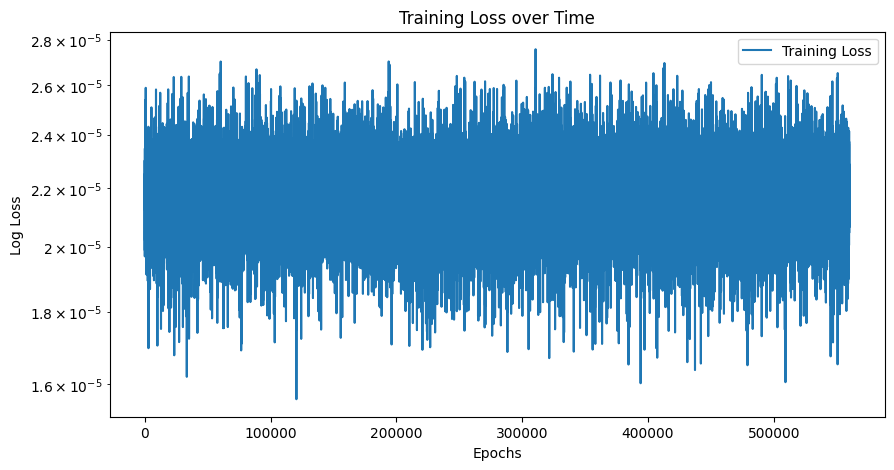

Finished Training
Average loss: 0.021900279817991055


In [13]:
# train the network
train(model, train_loader, criterion, optimizer, epochs)

# test the network
test(model, test_loader)

In [ ]:
print(train_data[100])
print(model.forward(train_data[100]))

print(torch.tensor(fourier(100, order), dtype=torch.float32))
print(model.forward(torch.tensor(fourier(100, order), dtype=torch.float32)))

tensor([ 2.3700e+02,  1.6883e-02,  9.9986e-01,  ..., -5.4033e-01,
         8.3221e-01, -5.5446e-01])
tensor([0.], grad_fn=<ReluBackward0>)
tensor([ 1.0000e+02,  7.1237e-03,  9.9997e-01,  ..., -9.1585e-01,
        -4.0804e-01, -9.1296e-01])
tensor([0.], grad_fn=<ReluBackward0>)


In [ ]:
# save the model
torch.save(model.state_dict(), f"fourierModel_order_{order}.pt")


In [ ]:
# load the model if needed
model = Net(order)
model.load_state_dict(torch.load(f"fourierModel_order_{order}.pt"))
model.eval()

Net(
  (fc1): Linear(in_features=1001, out_features=1001, bias=True)
  (fc2): Linear(in_features=1001, out_features=1, bias=True)
)

In [ ]:


generateWAV(2,"final")



100%|██████████| 88200/88200 [00:52<00:00, 1671.61it/s]


File Generated: ./WAV/new_wav_order_500_epoch_final.wav


100%|██████████| 88200/88200 [00:00<00:00, 1007331.93it/s]
